In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [5]:
import numpy as np
from scipy.stats import rankdata

# import phys.dataset_augment_utils as dataset_augment_utils
# import phys.data_utils as phys_data_utils
# import phys.phys_utils as phys_utils
import utils.dataset_augment_utils as dataset_augment_utils
import utils.data_utils as phys_data_utils
import utils.phys_utils as phys_utils

In [6]:
data = phys_data_utils.load_neural_dataset(timebinsize=50, subject_id='all_hand_dmfc', recompute_augment=True)

data_aug = dataset_augment_utils.augment_data_structure(data)


In [7]:
def make_axis_nice(ax, offset=5):
    sns.despine(ax=ax, offset=offset)
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    return

def smooth(x, win=4, sd=1):
    # typically 50ms sd, 200ms span, but here working on 50ms binned data.
    from scipy import signal
    filt = signal.gaussian(win, std=sd)
    filt = filt / np.nansum(filt)
    return np.convolve(x, filt, 'same') 

def smooth_mat(x, win=4, sd=1):
    x2 = np.ones(x.shape) * np.nan
    for i in range(x2.shape[0]):
        x2[i,:] = smooth(x[i,:], win=win, sd=sd)
    return x2

def midrange(x):
    return (x - np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def plot_lines_with_color(x, cols, smooth=False, axes=None):
    if smooth:
        x = smooth_mat(x)
    ylimits = [np.nanmin(x)*0.95, np.nanmax(x)*1.1]
    if axes is None:
        f,axes = plt.subplots(1, 1, figsize=(4,3))
        for tr_i in range(x.shape[0]):
            axes.plot(x[tr_i,:], color=cols[tr_i], alpha=0.5)
        axes.set_ylim(ylimits)
        axes.set_yticks([])
        axes.set_xticklabels([])
        sns.despine(ax=axes, offset=5)
            
    plt.tight_layout()
    return
#     f.savefig('%s/path_%s_%d.pdf' % (figsavepath, condition, nidx))

all_cols = {}
for colorvar in ['x0', 'y0', 'n_bounce_correct', 'yf',
                 'dx', 'dy', 'speed0', 'heading0',
                 'paddle_error', 'paddle_error_signed']:
    cax = midrange(rankdata(data_aug['meta'][colorvar]))
    all_cols[colorvar] = plt.cm.plasma(cax)

In [8]:

def plot_response_over_2d_var(plot_c, frame_x, frame_y, 
                              mask_fn='start_end_pad0', condition='occ',
                             f=None, axes=None, markersize=10):
    plot_x = data_aug['behavioral_responses'][condition][frame_x]
    plot_y = data_aug['behavioral_responses'][condition][frame_y]
    mask = data_aug['masks'][condition][mask_fn]

    plot_x = phys_utils.apply_mask(plot_x, mask)
    plot_y = phys_utils.apply_mask(plot_y, mask)
    plot_c = phys_utils.apply_mask(plot_c, mask)

    cmap_limits = np.percentile(plot_c[np.isfinite(plot_c)], [5,95])

    if axes is None:
        f,axes = plt.subplots(1,1,figsize=(6,6))
    axes.scatter(plot_x.flatten(), plot_y.flatten(), c=plot_c.flatten(), s=markersize, 
                 cmap=plt.cm.viridis, vmin=cmap_limits[0], vmax=cmap_limits[1])
    axes.set_xlabel(frame_x)
    axes.set_ylabel(frame_y)
    axes.set_aspect(1.0)
    if frame_x == 'ball_pos_x_TRUE':
        axes.plot([-10, 10], [10,10], 'k--', lw=3)
        axes.plot([-10, 10], [-10,-10], 'k--', lw=3)
        axes.plot([-10, -10], [-10,10], 'k--', lw=3)
        axes.plot([10, 10], [-10,10], 'k--', lw=3)
        axes.plot([5, 5], [-10,10], 'k--', lw=2)
        plt.axis('off')
    plt.tight_layout()

    return f, axes

In [14]:

colorvar = 'yf'
cols = all_cols[colorvar]
timebin = 50
condition = 'occ'
linestyles = [':', '-']

def plot_trace_base(xdata, mask_fn, ax, linestyle, realign=False):
    mask = data_aug['masks'][condition][mask_fn]
    x_masked = phys_utils.apply_mask(xdata, mask)
    if realign:
        x_masked = phys_utils.realign_masked_data(x_masked)

    time_ax = [ti*timebin for ti in range(x_masked.shape[1])]
    
    for xi in range(x_masked.shape[0]):
        col_curr = cols[xi]
        ax.plot(time_ax, x_masked[xi,:], '-', color=col_curr, ls=linestyle)
        first_nnan = np.nonzero(np.isfinite(x_masked[xi,:]))[0][0]
        last_nnan = np.nonzero(np.isfinite(x_masked[xi,:]))[0][-1]
        ax.plot(time_ax[first_nnan], x_masked[xi,first_nnan], 'wo', mec=col_curr)
        ax.plot(time_ax[last_nnan], x_masked[xi,last_nnan], 'wo', mec=col_curr)
    return time_ax, x_masked

def plot_traces_over_epochs(xdata_, savefn=None):
    f,axes = plt.subplots(1,3,figsize=(12,3.5))
    full_mask = data_aug['masks'][condition]['start_end_pad0']
    xdata_ = phys_utils.apply_mask(xdata_, full_mask)
    mm, MM = np.nanmin(xdata_), np.nanmax(xdata_)
    dr = MM - mm
    ylim = [np.nanmin(xdata_) - dr*0.1, np.nanmax(xdata_) + dr*0.1]
    
    for mfni, mask_fn in enumerate(['start_end_pad0','start_occ_pad0', 'occ_end_pad0']):
        ax = axes[mfni]
        if mask_fn == 'start_end_pad0':
            for m_idx, mask_fn_2 in enumerate(['start_occ_pad0', 'occ_end_pad0']):
                plot_trace_base(xdata_, mask_fn_2, ax, linestyles[m_idx])
        else:
            plot_trace_base(xdata_, mask_fn, ax, '-', realign=True)
        ax.set_ylim(ylim)
        sns.despine(ax=ax, offset=5)
        ax.spines['left'].set_linewidth(2)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['bottom'].set_color('black')
        plt.tight_layout()
    if savefn is not None:
        f.suptitle(savefn)
    return

# neural components

In [10]:
method = 'FactorAnalysis'
ncomp = 50
factor_fn = 'neural_responses_reliable_%s_%d' % (method, ncomp)
condition = 'occ'
FR_embed = data_aug[factor_fn][condition]
mask_fn = 'start_end_pad0'
mask = data_aug['masks'][condition][mask_fn]
print(FR_embed.shape)
print(mask.shape)



(50, 79, 100)
(79, 100)


[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950]
[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 

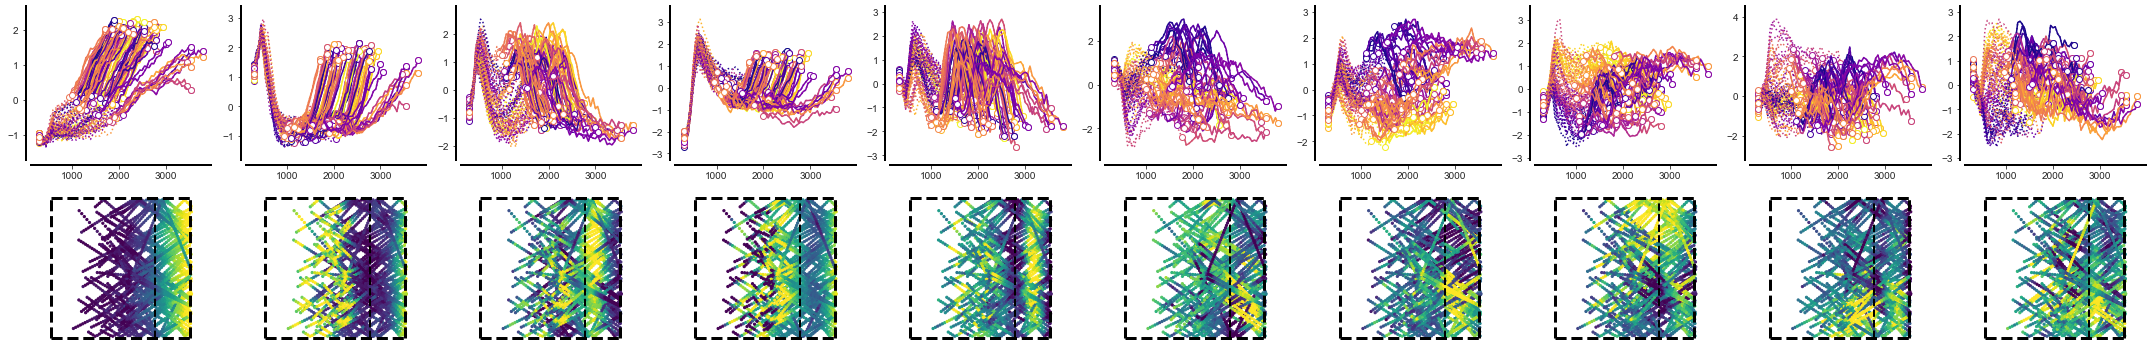

In [15]:
# combined plot

colorvar = 'yf'
cols = all_cols[colorvar]
timebin = 50
condition = 'occ'
linestyles = [':', '-']

f,axes = plt.subplots(2,10,figsize=(30,5))
for i in range(10):
    data_fr = FR_embed[i]
    mm, MM = np.nanmin(data_fr), np.nanmax(data_fr)
    dr = MM - mm
    ylim = [np.nanmin(data_fr) - dr*0.1, np.nanmax(data_fr) + dr*0.1]
    
    ax = axes[0,i]
    for m_idx, mask_fn_2 in enumerate(['start_occ_pad0', 'occ_end_pad0']):
        t,x_masked = plot_trace_base(data_fr, mask_fn_2, ax, linestyles[m_idx])
        print(t)
        np.savetxt('%s_%s.csv'%(i,mask_fn_2),x_masked, fmt='%5.3f', delimiter=',', newline='\n')
    ax.set_ylim(ylim)
    make_axis_nice(ax)
    
    ax = axes[1,i]
    plot_response_over_2d_var(FR_embed[i], 'ball_pos_x_TRUE', 'ball_pos_y_TRUE', 
                              mask_fn='start_end_pad0', condition=condition, 
                              f=f, axes=ax, markersize=5)
    ax.set_axis_off()
# plt.tight_layout()
    

In [12]:
# for i in range(10):
#     plot_traces_over_epochs(FR_embed[i], savefn='FR-%s%d' % (method, i))

In [13]:

# # method = 'FactorAnalysis'
# # FR_embed, transformer_ = phys_utils.get_embedding(FR, m, method=method, n_components=10)
# for i in range(10):
#     fntag = 'FR-%s%d' % (method, i)
#     f,axes = plot_response_over_2d_var(FR_embed[i], 'ball_pos_x_TRUE', 'ball_pos_y_TRUE',
#                               mask_fn='start_end_pad0', condition='occ')